# MNIST

In [35]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

## Global config

In [ ]:
# TODO

## Load data

In [36]:
mnist_28x28_train = np.load("mnist_28x28_train.npy")
mnist_8x8_train = np.load("mnist_8x8_train.npy")
train_labels = np.load("train_labels.npy")

mnist_28x28_test = np.load("mnist_28x28_test.npy")
mnist_8x8_test = np.load("mnist_8x8_test.npy")

## Helpers

In [37]:
# TODO
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

def k_fold_fit_and_evaluate(X, y, model, scoring_method, n_splits=5):
    # define evaluation procedure
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    # evaluate model
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=cv, n_jobs=-1)
       
    return scores["test_score"]

scoring_method = make_scorer(lambda prediction, true_target: f1_score(prediction, true_target, average="micro"))

In [38]:
models = {
    "GaussianNB": GaussianNB(),
    "DummyClassifier": DummyClassifier(strategy="most_frequent"),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C=10, kernel="poly", random_state=42),
    "LogisticRegression": LogisticRegression(C=10, random_state=42, max_iter=1000)
}

##  Data exploration

### Question 1
Hint: `plt.imshow`

In [39]:
print(np.unique(train_labels))
print("Train 8 shape: ", mnist_8x8_train.shape)
print("Train 28 shape: ", mnist_28x28_train.shape)
print("Test 8 shape: ", mnist_8x8_test.shape)
print("Test 28 shape: ", mnist_28x28_test.shape)
print("Labels size: ", len(train_labels))
print(mnist_8x8_train)

[0 1 2 3 4 5 6 7 8 9]
Train 8 shape:  (3750, 8, 8)
Train 28 shape:  (3750, 28, 28)
Test 8 shape:  (1250, 8, 8)
Test 28 shape:  (1250, 28, 28)
Labels size:  3750
[[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...  92  22   0]
  [  0   0   0 ... 155  14   0]
  ...
  [  0   0  49 ...   0   0   0]
  [  0   0  98 ...   0   0   0]
  [  0   0  22 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   3  17 ...   9   1   0]
  [  0  28 176 ... 164  36   0]
  ...
  [  0   0   1 ...  27   0   0]
  [  0   0  24 ...   1   0   0]
  [  0   0  42 ...   0   0   0]]

 [[  0   0   1 ...   0   0   0]
  [  0   0  41 ...  21   1   0]
  [  0   5 139 ... 131  58   2]
  ...
  [  0  21 130 ...  86 112  14]
  [  0   2  57 ...  98  20   0]
  [  0   0   0 ...   1   0   0]]

 ...

 [[  0   0   0 ...   0   0   0]
  [  0   0   7 ...  20   1   0]
  [  0   0  11 ...  96  36   1]
  ...
  [  0   1  25 ...  27   0   0]
  [  0   2  70 ...  17   0   0]
  [  0   0  13 ...   1   0   0]]

 [[  0   0   0 ...   0   0   0]
 

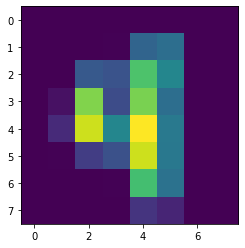

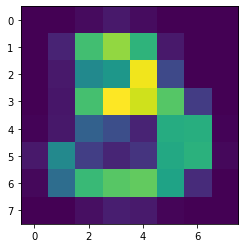

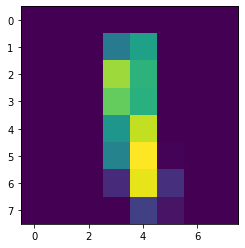

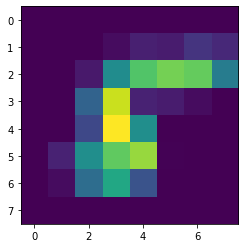

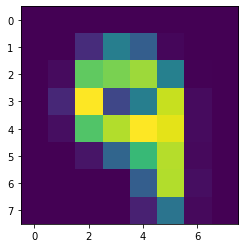

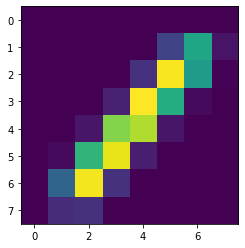

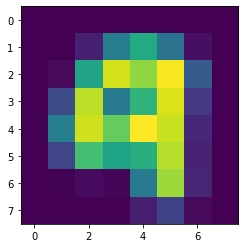

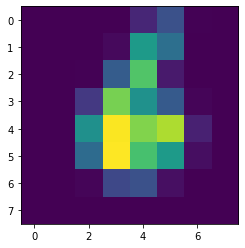

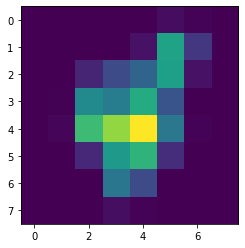

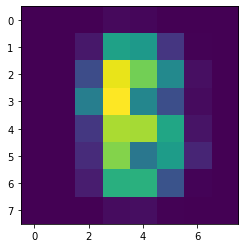

In [41]:
# TODO
i = 0
for m in mnist_8x8_test:
    if i < 10:
        plt.imshow(m)
        plt.show()
        i += 1
    else:
        break
    

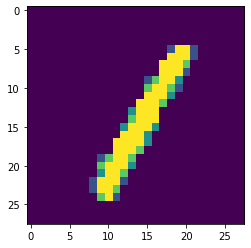

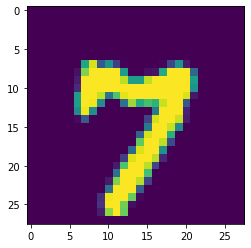

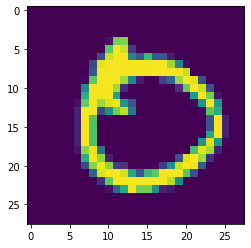

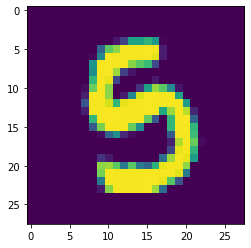

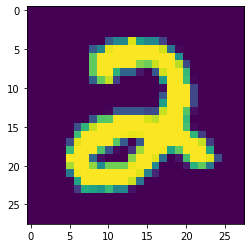

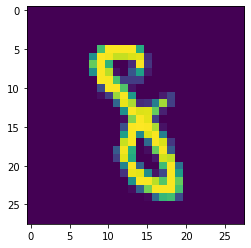

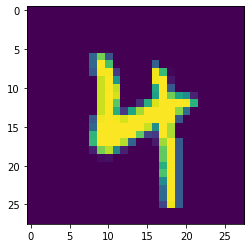

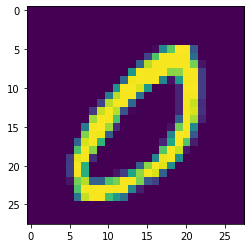

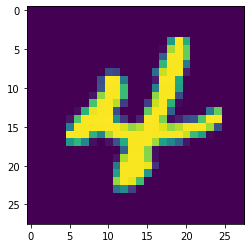

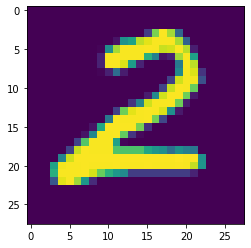

In [42]:
# TODO
i = 0
for m in mnist_28x28_train:
    if i < 10:
        plt.imshow(m)
        plt.show()
        i += 1
    else:
        break

##  Data Preparations

### Question 1

In [43]:
# Scale all values to between 0 and 1
# Didn't make any difference
scale_train_8 = mnist_8x8_train / 255.0
scale_test_8 = mnist_8x8_test / 255.0
scale_train_28 = mnist_28x28_train / 255.0
scale_test_28 = mnist_28x28_test / 255.0

In [44]:
# Reshape all images from NxN to N^2x1.
from sklearn.preprocessing import Normalizer

def reshape_fit_trans(mnist_input):
    nsam_input, nx_input, ny_input = mnist_input.shape
    tmp_train_input = mnist_input.reshape(nsam_input, nx_input * ny_input)
    return Normalizer().fit_transform(tmp_train_input)
    #X_reshape_8_train = X_fit_trans_8_train.reshape(nsam_train, nxx, nyy)

X_fit_trans_8_train = reshape_fit_trans(scale_train_8)
X_fit_trans_8_test = reshape_fit_trans(scale_test_8)
X_fit_trans_28_train = reshape_fit_trans(scale_train_28)
X_fit_trans_28_test = reshape_fit_trans(scale_test_28)

## Experiments

### Question 1

In [7]:
# Split data
from sklearn.model_selection import train_test_split

X8_train, X8_test, y8_train, y8_test = train_test_split(X_fit_trans_8_train, 
                train_labels, test_size=0.1, random_state=42, 
                shuffle=True, stratify=train_labels)

X28_train, X28_test, y28_train, y28_test = train_test_split(X_fit_trans_28_train, 
                train_labels, test_size=0.1, random_state=42, 
                shuffle=True, stratify=train_labels)

### Question 2

In [8]:
from sklearn.metrics import f1_score, accuracy_score
from tabulate import tabulate
# TODO
def fit_predict(X_train, X_test, y_train, y_test):
    table = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f = f1_score(pred, y_test, average='weighted')
        acc = accuracy_score(pred, y_test)
        
        table.append([name, f, acc])
    return table

In [9]:
# k-fold
def kfold_fit_eval(X_train, y_train):
    table2 = []
    for name, model in models.items():
        tmp_acc = k_fold_fit_and_evaluate(X_train, y_train, model, scoring_method)
        m_acc = np.mean(tmp_acc)
        std_acc = np.std(tmp_acc)
        table2.append([name, m_acc, std_acc])
    return table2

In [31]:
# X_kfold_train, table = 
table_8 = fit_predict(X8_train, X8_test, y8_train, y8_test)
table2_8 = kfold_fit_eval(X8_train, y8_train)
print(tabulate(table_8, headers=['Name', 'F1', 'Accuracy']))
print(tabulate(table2_8, headers=['Name', 'Mean', 'Std_Acc']))

Name                          F1    Accuracy
----------------------  --------  ----------
GaussianNB              0.663124    0.626667
DummyClassifier         0.188406    0.104
DecisionTreeClassifier  0.762462    0.762667
KNeighborsClassifier    0.930339    0.930667
SVM                     0.95991     0.96
LogisticRegression      0.898203    0.898667
Name                         Mean     Std_Acc
----------------------  ---------  ----------
GaussianNB              0.596444   0.0383312
DummyClassifier         0.0974815  0.00533333
DecisionTreeClassifier  0.788444   0.0129966
KNeighborsClassifier    0.939556   0.00865875
SVM                     0.943704   0.00761199
LogisticRegression      0.893333   0.0096011


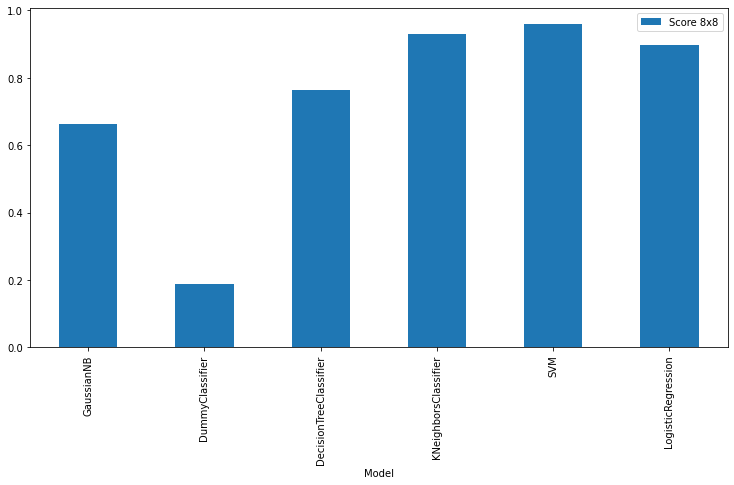

In [34]:
graph = [['GaussianNB', 0.663124],
['DummyClassifier', 0.188406],
['DecisionTreeClassifier', 0.762462],
['KNeighborsClassifier', 0.930339],
['SVM', 0.95991],
['LogisticRegression', 0.898203]]

df = pd.DataFrame(graph, columns=["Model", "Score 8x8",])
df.plot.bar('Model', ["Score 8x8"], figsize=(12.5,6.25))

In [51]:
# model_name = list(zip(*table_8))[0]
# f1 = list(zip(*table_8))[1]
# acc = list(zip(*table_8))[2]

# df = pd.DataFrame(table_8, columns=["Model", "F1", "Accuracy"])
# df.plot('Model', ['F1', 'Accuracy'], kind='bar')

In [11]:
#X_kfold_train_28, table = 
table_28 = fit_predict(X28_train, X28_test, y28_train, y28_test)
table2_28 = kfold_fit_eval(X28_train, y28_train)
print(tabulate(table_28, headers=['Name', 'F1', 'Accuracy']))
print(tabulate(table_28, headers=['Name', 'Mean', 'Std_Acc']))

Name                          F1    Accuracy
----------------------  --------  ----------
GaussianNB              0.623049    0.581333
DummyClassifier         0.188406    0.104
DecisionTreeClassifier  0.723819    0.72
KNeighborsClassifier    0.936158    0.936
SVM                     0.949388    0.949333
LogisticRegression      0.89589     0.896
Name                        Mean    Std_Acc
----------------------  --------  ---------
GaussianNB              0.623049   0.581333
DummyClassifier         0.188406   0.104
DecisionTreeClassifier  0.723819   0.72
KNeighborsClassifier    0.936158   0.936
SVM                     0.949388   0.949333
LogisticRegression      0.89589    0.896


In [ ]:
# t2 = list(zip(*table_28))
# for i, e in enumerate(t2[1]):
#     table_28[i].append(e)
#     table_28[i].append(t2[2][i])
# print(tabulate(table_28, headers=['Name', 'F1', 'Accuracy', 'Mean', 'Std_Acc']))

In [ ]:
# model_name = list(zip(*table_28))[0]
# f1 = list(zip(*table_28))[1]
# acc = list(zip(*table_28))[2]

# df = pd.DataFrame(table_28, columns=["Model", "F1", "Accuracy", 'Mean', 'Standard Deviation'])
# df.plot('Model', ['F1', 'Accuracy', 'Mean', 'Standard Deviation'], kind='bar')

### Question 3

In [16]:
from sklearn.model_selection import GridSearchCV

random_state = 42
n_splits = 5

model_parameters = {
    "GaussianNB": {
        
    },
    "DummyClassifier": {
        'strategy': ["most_frequent"]
    },
    "DecisionTreeClassifier": {
        'random_state': [42],
        'max_depth': [None, 2, 3, 4, 5, 6, 7, 10, 42]
    },
    # START ANSWER
    'KNeighborsClassifier': {
        'n_neighbors': [2, 3, 4, 5, 6, 7, 10, 11, 25, 42],
        'weights': ['distance', 'uniform'],
        "n_jobs": [-1]
        #'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    },
    'SVM': {
        'random_state': [42],
        'C': [0.1, 1, 2, 2.25, 2.3, 3.75, 2.4, 2.31, 2,42, 2,43, 2,44, 2,45, 2.5, 2.6, 2.675, 2.7, 2.75, 
              2.8, 2.81, 2.82, 2.821, 2,822, 2,823, 2,824, 2.825, 2.83, 2.85, 3, 3.25, 3,5, 4, 4,5 , 5, 
              6, 7, 8, 9, 10, 11, 12, 15, 100, 1000],
        #'gamma': [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0005, 0.0001, 'scale'],
        'kernel': ['poly', 'sigmoid', 'linear', 'rbf']
    },
    'LogisticRegression':{
        'C': [0.1, 1, 2, 2.25, 2.3, 3.75, 2.4, 2.31, 2,42, 2,43, 2,44, 2,45, 2.5, 2.6, 2.675, 2.7, 2.75, 
              2.8, 2.81, 2.82, 2.821, 2,822, 2,823, 2,824, 2.825, 2.83, 2.85, 3, 3.25, 3,5, 4, 4,5 , 5, 
              6, 7, 8, 9, 10, 11, 12, 15, 100, 1000],
        'penalty': ['none', 'elasticnet', 'l2', 'l1'],
        'random_state': [42]
    }
    # END ANSWER
}


In [17]:
for model_name, parameters in model_parameters.items():
    model = models[model_name]
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, 
                               scoring=scoring_method).fit(X_fit_trans_8_train, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

GaussianNB
- best_score = 0.6026666666666666
best paramters:
DummyClassifier
- best_score = 0.09706666666666668
best paramters:
- strategy most_frequent
DecisionTreeClassifier
- best_score = 0.7845333333333333
best paramters:
- max_depth None
- random_state 42
KNeighborsClassifier
- best_score = 0.9410666666666666
best paramters:
- n_jobs -1
- n_neighbors 4
- weights uniform
SVM
- best_score = 0.9544
best paramters:
- C 2.82
- kernel poly
- random_state 42
LogisticRegression
- best_score = 0.8984
best paramters:
- C 100
- penalty l2
- random_state 42


In [18]:
for model_name, parameters in model_parameters.items():
    model = models[model_name]
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, 
                               scoring=scoring_method).fit(X_fit_trans_28_train, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

GaussianNB
- best_score = 0.5826666666666667
best paramters:
DummyClassifier
- best_score = 0.09706666666666668
best paramters:
- strategy most_frequent
DecisionTreeClassifier
- best_score = 0.7381333333333333
best paramters:
- max_depth 10
- random_state 42
KNeighborsClassifier
- best_score = 0.9418666666666666
best paramters:
- n_jobs -1
- n_neighbors 4
- weights distance
SVM
- best_score = 0.9573333333333334
best paramters:
- C 3.75
- kernel poly
- random_state 42
LogisticRegression
- best_score = 0.8946666666666667
best paramters:
- C 6
- penalty l2
- random_state 42


### Question 4 

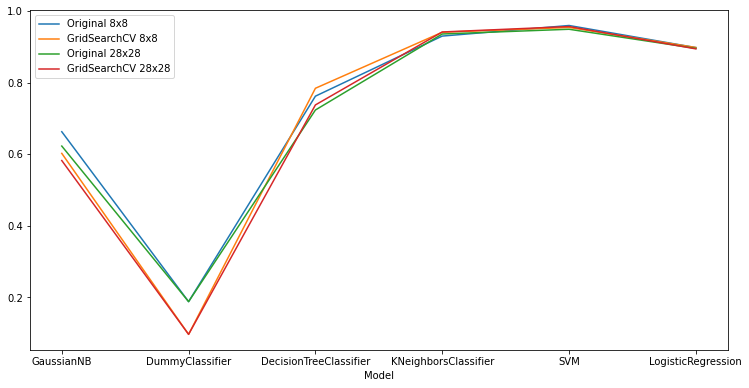

In [30]:
#TODO
results = [['GaussianNB', 0.663124, 0.6026, 0.623049, 0.5826],
['DummyClassifier', 0.188406, 0.097, 0.188406, 0.097],
['DecisionTreeClassifier', 0.762462, 0.78453, 0.723819, 0.738],
['KNeighborsClassifier', 0.930339, 0.94106, 0.936158, 0.9418],
['SVM', 0.95991, 0.9544, 0.949388, 0.957],
['LogisticRegression', 0.898203, 0.8984, 0.89589, 0.8946]]

df = pd.DataFrame(results, columns=["Model", "Original 8x8", 
            "GridSearchCV 8x8", "Original 28x28", "GridSearchCV 28x28"])
df.plot('Model', ["Original 8x8", "GridSearchCV 8x8", "Original 28x28", 
                  "GridSearchCV 28x28"], figsize=(12.5,6.25))

### Question 5

In [ ]:
#TODO

### Question 6

In [49]:
#TODO
prediction = np.array([-1] * len(mnist_8x8_test))
#TODO replace this with you own prediction

svm_final = SVC(C=3.75, kernel="poly", random_state=42)
svm_final.fit(X28_train, y28_train)
prediction = svm_final.predict(X_fit_trans_28_test)
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_mnist.txt", index=False, header=False)

In [ ]:
def remove_constant_pixels(pixels_df):
    """Removes from the images the pixels that have a constant intensity value,
    either always black (0) or white (255)
    Returns the cleared dataset & the list of the removed pixels (columns)"""

    #Remove the pixels that are always black to compute faster
    changing_pixels_df = pixels_df.loc[:]
    dropped_pixels_b = []

    #Pixels with max value =0 are pixels that never change
    for col in pixels_df:
        if changing_pixels_df[col].max() == 0:
            changing_pixels_df.drop(columns=[col], inplace=True)
            dropped_pixels_b.append(col)
    print("Constantly black pixels that have been dropped: {}".format(dropped_pixels_b))


    #Same with pixels with min=255 (white pixels)
    dropped_pixels_w = []
    for col in changing_pixels_df:
        if changing_pixels_df[col].min() == 255:
            changing_pixels_df.drop(columns=[col], inplace=True)
            dropped_pixel_w.append(col)
    print("\n Constantly white pixels that have been dropped: {}".format(dropped_pixels_b))

    print(changing_pixels_df.head())
    print("Remaining pixels: {}".format(len(changing_pixels_df.columns)))
    print("Pixels removed: {}".format(784-len(changing_pixels_df.columns)))
    
    return changing_pixels_df, dropped_pixels_b + dropped_pixels_w

In [ ]:
# Rescale and convert to black and white
np.seterr(divide='ignore', invalid='ignore')

def rescale_decolourize(image):
    #print(image)
    pmin, pmax = image.min(), image.max()
    rescaled_image = 255 * (image - pmin) / (pmax - pmin)
    rescaled_pixels = rescaled_image
    print(rescaled_pixels)

    i = 0
    for m in rescaled_pixels:
        if i < 10:
            plt.imshow(m)
            plt.show()
            i += 1
        else:
            pass

    # Only black or white pixels
    for i in range(len(image[0])):
        for j, x in enumerate(rescaled_pixels[i]):
            image[i][j] = 0 if x < 128 else 255
    return image
    # return image.apply(lambda x: 0 if x<128 else 255)
    # bw_image = image.values.reshape((8,8))
    # return bw_image